In [158]:
# 데이터 처리, 모델 구축, 시각화를 위한 주요 라이브러리 및 모듈을 불러옵니다.
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

In [159]:
# 쥬피터 노트북용 데이터 불러오기
df_train = pd.read_csv('./sales_train.csv')
df_categories = pd.read_csv("./item_categories.csv")
df_items = pd.read_csv("./items-translated.csv", encoding='cp1252') # 번역 후 파일을 input 폴더에 올려두었습니다. 파일명: items_translated
df_shops = pd.read_csv("./shops_graded.csv", encoding='cp1252') # 매장 등급 추가한 파일을 input 폴더에 올려두었습니다. 파일명: shops_graded
df_test = pd.read_csv("./test.csv")
calendar = pd.read_csv("./calendar.csv")

In [160]:
# df_shops

In [161]:
# 데이터 병합
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y')
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [162]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})
# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [163]:
# dat 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [164]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",A,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",C,1,1,Tyumen,Games,999.0,17982.0,2014,2,23,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow MTRC ""Afers Mall""",A,0,1,Moscow,Games,999.0,17982.0,2014,3,23,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",C,1,0,Tyumen,Games,999.0,17982.0,2014,5,1,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow TRK ""Atrium""",A,0,1,Moscow,Games,999.0,17982.0,2014,7,12,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,THE MAN OF RAIN (BD),37,Cinema - Blu -Ray,"SPb TK ""Nevsky Center""",A,0,0,SanktPetersburg,Cinema,499.0,8982.0,2014,12,31,2014-12


In [165]:
# 중복 제거 # 6개 건
df_train.drop_duplicates(inplace=True)

In [166]:
# df_train

In [167]:
test = pd.read_csv('./test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [168]:
data = df_train.copy()

In [169]:
# data

In [170]:
data = data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 해당 컬럼들은 각 id컬럼과 1대1 매칭이므로 둘 중 하나는 제거

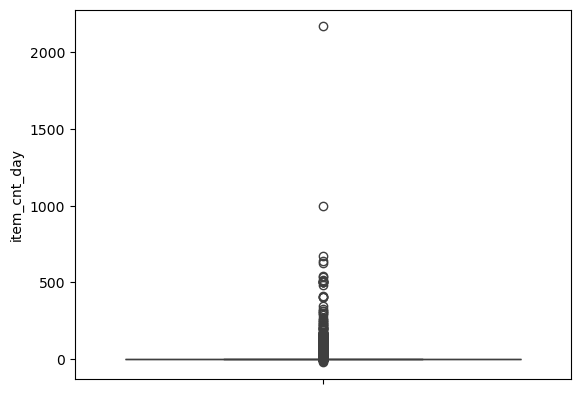

In [171]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

sns.boxplot(y='item_cnt_day', data=data);
plt.show()

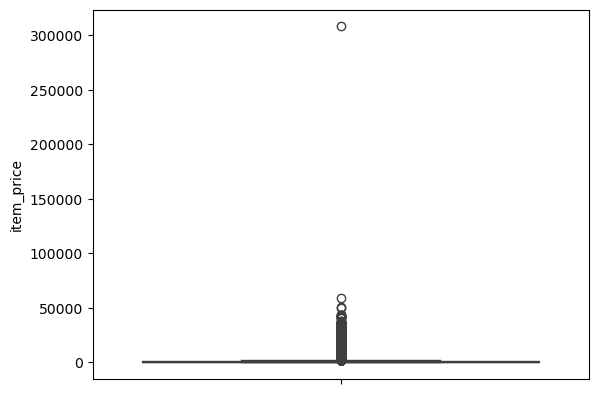

In [172]:
sns.boxplot(y='item_price', data=data);
plt.show()

### 이상치 제거

In [173]:
# 이상치 조건에 해당하는 행들 인덱스 추출
outlier_condition = (data['item_cnt_day'] >= 1000) | (data['item_price'] >= 100000)

# 이상치가 아닌 데이터만 필터링
data_cleaned = data[~outlier_condition].copy()

# 결과 확인 (이상치 제거 후)
print(data_cleaned.shape)

(2935840, 18)


In [174]:
data_cleaned.isna().sum()

date                0
date_block_num      0
shop_id             0
item_id             0
item_price          0
item_cnt_day        0
item_category_id    0
shop_grade          0
holiday             0
weekend             0
city                0
sub_category        0
rub_amount          0
krw_amount          0
year                0
month               0
day                 0
year_month          0
dtype: int64

In [175]:
# 그룹화하여 월별 월간 판매량
group = data_cleaned.groupby('date_block_num').agg({'item_cnt_day': 'sum'})
group.reset_index() # 인덱스 재설정

,date_block_num,item_cnt_day
0,0,131478.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


In [176]:
from itertools import product

train = []
# 월ID, 상점ID, 상품ID 조합 생성 
for i in data_cleaned['date_block_num'].unique():
    all_shop = data_cleaned.loc[data_cleaned['date_block_num']==i, 'shop_id'].unique()
    all_item = data_cleaned.loc[data_cleaned['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처
# 리스트 타입인 train을 DataFrame 타입으로 변환 
train = pd.DataFrame(np.vstack(train), columns=idx_features)

train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913799,33,21,7635
10913800,33,21,7638
10913801,33,21,7640
10913802,33,21,7632


### Feature Engineering 타깃값 추가 (월간 판매량)

In [177]:
# idx_features를 기준으로 그룹화해 판매량 합 구하기 
group = data_cleaned.groupby(idx_features).agg({'item_cnt_day': 'sum'})
# 인덱스 재설정
group = group.reset_index()
# 피처명을 '판매량'에서 '월간 판매량'으로 변경
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly'})

group

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1609117,33,59,22087,6.0
1609118,33,59,22088,2.0
1609119,33,59,22091,1.0
1609120,33,59,22100,1.0


In [178]:
# train과 group 병합하기
train = train.merge(group, on=idx_features, how='left')

train

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913799,33,21,7635,NaN
10913800,33,21,7638,NaN
10913801,33,21,7640,NaN
10913802,33,21,7632,NaN


In [179]:
import gc # 가비지 컬렉터 불러오기

del group # 더는 사용하지 않는 변수 지정
gc.collect(); # 가비지 컬렉션 수행

### Feature Engineering test data 이어붙이기
train data의 월ID는 0~33으로 마지막이 2015년 10월인데, test data는 2015년 11월이므로 월ID feature를 34로 설정한다.  
test data에서 식별자 역할을 하는 ID를 제외하고 test data를 train data와 merge

In [180]:
test['date_block_num'] = 34  # 2015년 11월 예측 대상 월 번호

all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True, 
                     keys=idx_features) # 이어붙이는 기준이 되는 피처

# 결측값 0으로 채우기
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0


### Feature Engineering 나머지 데이터 병합 (최종 데이터 생성)

In [181]:
all_data

,date_block_num,shop_id,item_id,item_cnt_monthly
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0


In [182]:
import numpy as np
import pandas as pd

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        dtype = df[col].dtype

        if pd.api.types.is_object_dtype(dtype):
            # object는 건너뜀
            continue
        elif pd.api.types.is_bool_dtype(dtype):
            df[col] = df[col].astype('int8')
        elif pd.api.types.is_integer_dtype(dtype):
            df[col] = pd.to_numeric(df[col], downcast='integer')
        elif pd.api.types.is_float_dtype(dtype):
            # 소수점이 없는 float는 int로 변환
            col_non_na = df[col].dropna()
            if (col_non_na == col_non_na.astype(int)).all():
                df[col] = pd.to_numeric(df[col], downcast='integer')
            else:
                df[col] = pd.to_numeric(df[col], downcast='float')
        else:
            # 예: datetime, category 등은 건너뜀
            continue

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 압축됨'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [183]:
all_df = [df_train, df_shops, df_items, df_categories, test]
for df in all_df:
    df = downcast(df)

38.1% 압축됨
26.7% 압축됨
54.2% 압축됨
39.8% 압축됨
75.0% 압축됨


In [184]:
all_data = all_data.merge(df_shops, on='shop_id', how='left')
all_data = all_data.merge(df_items, on='item_id', how='left')
all_data = all_data.merge(df_categories, on='item_category_id', how='left')
all_data = all_data.drop(['shop_name', 'item_name_translated', 'item_category_name'], axis=1)
# 데이터 다운캐스팅
all_data = downcast(all_data)

# 가비지 컬렉션
del df_shops, df_items, df_categories
gc.collect();

63.4% 압축됨


In [185]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_monthly'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_monthly'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_monthly'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_monthly']
y_train = y_train.clip(0, 20) # 타깃값을 0 ~ 20로 제한
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_monthly']
y_valid = y_valid.clip(0, 20)

학습 데이터 X_train, y_train : 33월 이전 데이터로 학습  
검증 데이터 X_valid, y_valid : 33월 데이터로 모델 검증  
테스트 데이터 X_test: 34월 데이터로 예측  

In [186]:
X_train.shape

(10675632, 5)

In [187]:
y_train.shape

(10675632,)

In [188]:
X_valid.shape

(238172, 5)

In [189]:
y_valid.shape

(238172,)

In [190]:
X_train = X_train.drop('shop_grade', axis=1)
X_valid = X_valid.drop('shop_grade', axis=1)
X_test = X_test.drop('shop_grade', axis=1)

In [191]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_valid = model.predict(X_valid)
y_pred_valid = np.clip(y_pred_valid, 0, 20)
mse = mean_squared_error(y_valid, y_pred_valid)
rmse = np.sqrt(mse)
print(f"검증 RMSE: {rmse:.4f}")
# y_pred_test = model.predict(X_test)

검증 RMSE: 1.1368


In [192]:
y_pred_test = model.predict(X_test)

y_pred_test = model.predict(X_test)
y_pred_test = np.clip(y_pred_test, 0, 20)

print(y_pred_test)

[0.44613277 0.20819708 0.44453035 ... 0.19413805 0.26050265 0.4328497 ]


## 성능 개선 개별 데이터 피처 엔지니어링

### 이상치 제거 및 전처리

In [193]:
df_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,shop_grade,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.0,1,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",C,1,0,Yaroslavl,Cinema,999.0,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.0,1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,1,0,Moscow,Music,899.0,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.0,-1,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",A,0,1,Moscow,Music,-899.0,-16182.0,2013,1,5,2013-01


In [194]:
# 판매가가 0보다 큰 데이터 추출
df_train = df_train[df_train['item_price'] > 0]
# 판매가가 50,000보다 작은 데이터 추출
df_train = df_train[df_train['item_price'] < 50000]

# 판매량이 0보다 큰 데이터 추출
df_train = df_train[df_train['item_cnt_day'] > 0]
# 판매량이 1,000보다 작은 데이터 추출
df_train = df_train[df_train['item_cnt_day'] < 1000]

상점명을 조금 다르게 기입해서 같은 상점인데 다르게 기록되어 있는 상점이 4쌍 있기에 각 쌍의 상점ID를 수정해준다. 상점명은 어차피 제거할 것이기에 수정하지 않아도 된다. -> 수정하지않음

### 도시명은 범주형 피처이므로 레이블 인코딩

In [195]:
# df_train에서 shop_id와 city 정보만 추출 후 중복 제거
shop_city_map = df_train[['shop_id', 'city']].drop_duplicates()

# df_shops가 안 불러와지니까 shop_id만 따로 생성한 뒤 병합
shops = pd.DataFrame({'shop_id': df_train['shop_id'].unique()})
shops = shops.merge(shop_city_map, on='shop_id', how='left')

In [196]:
from sklearn.preprocessing import LabelEncoder

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 도시 피처 레이블 인코딩
shops['city'] = label_encoder.fit_transform(shops['city'])

In [197]:
# # item_id별 첫 판매 월 추출
# first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
# first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# # 새로운 DataFrame 생성
# items = first_sales_month.copy()

In [198]:
# item_id별 첫 판매 월 추출
first_sales_month = df_train.groupby('item_id', as_index=False)['date_block_num'].min()
first_sales_month.rename(columns={'date_block_num': 'first_sales_month'}, inplace=True)

# item_id별 item_category_id 추출 (중복 제거)
item_categories = df_train[['item_id', 'item_category_id']].drop_duplicates()
items = first_sales_month.copy()

In [199]:
items.head(3)

,item_id,first_sales_month
0,0,20
1,1,15
2,2,19


In [200]:
items['first_sales_month'].isna().sum()

0

In [201]:
# df_train['sub_category'].unique() # 5개로 줄이는 게 좋지만 일단 실행하기로 함

In [202]:
# item_category_id와 sub_category 정보를 df_train에서 추출 후 중복 제거
item_categories = df_train[['item_category_id', 'sub_category']].drop_duplicates().reset_index(drop=True)

In [203]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()

# 대분류 피처 레이블 인코딩
item_categories['sub_category'] = label_encoder.fit_transform(item_categories['sub_category'])

### 파생 변수 생성
- 월, 상점, 상품별 월간 판매량과 평균 판매가 변수를 만들고, 기준 feature별 상품 판매건수 feature를 만들어 준다.

In [204]:
# 충돌 방지를 위해 기존 컬럼 삭제
train = train.drop(columns=['item_cnt_monthly'], errors='ignore')

group = df_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_monthly', 'item_price': 'mean_item_price'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [205]:
# concat 전에 test에 item_cnt_monthly가 있으면 제거

### test data를 train에 합치기

In [206]:
# 테스트 데이터 월ID를 34로 설정
test['date_block_num'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


item_cnt_monthly컬럼이 하나가 되어야 함

In [207]:
# 테스트 데이터 월ID를 34로 설정
test['date_block_num'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


판매건수가 붙지 않는 문제 발생 -> 일단 진행

all_data에 item_category_id가 없어서 merge가 안 됨

In [208]:
all_data = downcast(all_data)

65.0% 압축됨


In [209]:
del shops, items, item_categories
gc.collect();

### 시차(time lag) feature 생성
타깃값과 관련된 "기준 feauture별 월간 평균 판매량" feature를 만들고 이를 활용해 시차 feature를 만들도록한다.

In [210]:
def add_mean_features(df, mean_features, idx_features):
    # 기준 피처 확인 
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]

    # 파생 피처명 설정 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'

    # 기준 피처를 토대로 그룹화해 월간 평균 판매량 구하기 
    group = df.groupby(idx_features).agg({'item_cnt_monthly': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_monthly': feature_name})

    # df와 group 병합 
    df = df.merge(group, on=idx_features, how='left')
    # 데이터 다운캐스팅 
    df = downcast(df, verbose=False)
    # 새로 만든 feature_name 피처명을 mean_features 리스트에 추가 
    mean_features.append(feature_name)

    # 가비지 컬렉션
    del group
    gc.collect()

    return df, mean_features

In [211]:
# 테스트 데이터 월ID를 34로 설정
test['date_block_num'] = 34

# train과 test 이어붙이기
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 결측값을 0으로 대체
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_monthly,mean_item_price
0,0,59,22154,1.0,999.0
1,0,59,2552,0.0,0.0
2,0,59,2554,0.0,0.0
3,0,59,2555,0.0,0.0
4,0,59,2564,0.0,0.0


In [212]:
# all_data와 df_train에 모두 존재하는 키를 기준으로 병합 (예: shop_id)
# df_train에서 중복 제거 후 city 컬럼만 추출
shop_city = df_train[['shop_id', 'city']].drop_duplicates()

# all_data에 병합 (중복 컬럼 방지)
all_data = all_data.merge(shop_city, on='shop_id', how='left')

all_data에 city컬럼을 merge 하였으므로 아래 행이 실행되어야 함

In [213]:
# 그룹화 기준 피처 중 '상품ID'가 포함된 파생 피처명을 담을 리스트
item_mean_features = []

# ['월ID', '상품ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# ['월ID', '상품ID', '도시']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

item_mean_features

['item_id별 평균 판매량', 'item_id city별 평균 판매량']

In [214]:
# item_id 기준으로 item_category_id 병합
item_category = df_train[['item_id', 'item_category_id']].drop_duplicates()
all_data = all_data.merge(item_category, on='item_id', how='left')

In [215]:
# 그룹화 기준 피처 중 '상점ID'가 포함된 파생 피처명을 담을 리스트
shop_mean_features = []

# ['월ID', '상점ID', '상품분류ID']로 그룹화한 월간 평균 판매량 파생 피처 생성
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

shop_mean_features

['shop_id item_category_id별 평균 판매량']

In [216]:
# def add_lag_features(df, lag_features_to_clip, idx_features, 
#                      lag_feature, nlags=3, clip=False):
#     # 시차 피처 생성에 필요한 DataFrame 부분만 복사 
#     df_temp = df[idx_features + [lag_feature]].copy() 

#     # 시차 피처 생성 
#     for i in range(1, nlags+1):
#         # 시차 피처명 
#         lag_feature_name = lag_feature +'_시차' + str(i)
#         # df_temp 열 이름 설정 
#         df_temp.columns = idx_features + [lag_feature_name]
#         # df_temp의 date_block_num 피처에 1 더하기 
#         df_temp['date_block_num'] += 1
#         # idx_feature를 기준으로 df와 df_temp 병합하기 
#         df = df.merge(df_temp.drop_duplicates(), 
#                       on=idx_features, 
#                       how='left')
#         # 결측값 0으로 대체 
#         df[lag_feature_name] = df[lag_feature_name].fillna(0)
#         # 0 ~ 20 사이로 제한할 시차 피처명을 lag_features_to_clip에 추가 
#         if clip: 
#             lag_features_to_clip.append(lag_feature_name)

#     # 데이터 다운캐스팅
#     df = downcast(df, False)
#     # 가비지 컬렉션
#     del df_temp
#     gc.collect()

#     return df, lag_features_to_clip

In [217]:
# def add_lag_features(df, lag_features_to_clip, idx_features, 
#                      lag_feature, nlags=3, clip=False):
#     df_temp = df[idx_features + [lag_feature]].copy()

#     for i in range(1, nlags + 1):
#         lag_feature_name = lag_feature + '_시차' + str(i)
        
#         # 복사 후 컬럼명 변경은 루프 안에서 이뤄져야 하되, 컬럼 수가 정확해야 함
#         df_shift = df_temp.copy()
#         df_shift['date_block_num'] += i
#         df_shift.rename(columns={lag_feature: lag_feature_name}, inplace=True)

#         df = df.merge(df_shift, on=idx_features, how='left')
#         df[lag_feature_name] = df[lag_feature_name].fillna(0)

#         if clip:
#             lag_features_to_clip.append(lag_feature_name)

#     df = downcast(df, False)
#     gc.collect()
#     return df, lag_features_to_clip


In [218]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    df_temp = df[idx_features + [lag_feature]].copy()

    for i in range(1, nlags + 1):
        lag_feature_name = f'{lag_feature}_시차{i}'

        df_shift = df_temp.copy()
        df_shift['date_block_num'] += i
        df_shift.rename(columns={lag_feature: lag_feature_name}, inplace=True)

        # 병합
        df = df.merge(df_shift, on=idx_features, how='left')

        # fillna 안전하게 적용
        if lag_feature_name in df.columns:
            df.loc[:, lag_feature_name] = df[lag_feature_name].fillna(0)
        else:
            print(f"[경고] 병합 후 {lag_feature_name} 컬럼이 존재하지 않습니다.")

        # 클리핑 대상 피처 추가
        if clip:
            lag_features_to_clip.append(lag_feature_name)

    df = downcast(df, False)
    gc.collect()
    return df, lag_features_to_clip


In [ ]:
lag_features_to_clip = [] # 0 ~ 20 사이로 제한할 시차 피처명을 담을 리스트
idx_features = ['date_block_num', 'shop_id', 'item_id'] # 기준 피처

# idx_features를 기준으로 월간 판매량의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3,
                                                  clip=True) # 값을 0 ~ 20 사이로 제한

In [ ]:
# idx_features를 기준으로 판매건수 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_monthly', 
                                                  nlags=3)

# idx_features를 기준으로 평균 판매가 피처의 세 달치 시차 피처 생성
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='mean_item_price', 
                                                  nlags=3)

In [ ]:
all_data

In [ ]:
print(all_data.columns.tolist())

In [ ]:
# idx_features를 기준으로 item_mean_features 요소별 시차 피처 생성
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 피처 제거
all_data = all_data.drop(item_mean_features, axis=1)

In [ ]:
# ['월ID', '상점ID', '상품분류ID']를 기준으로 shop_mean_features 요소별 시차 피처 생성
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 피처 제거
all_data = all_data.drop(shop_mean_features, axis=1)

In [ ]:
# 월ID 3미만인 데이터 제거
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

In [ ]:
# all_data

### 기타 feature engineering

In [ ]:
pd.set_option('display.max_columns', None)
all_data

In [ ]:
all_data['월간 판매량 시차평균'] = all_data[['item_cnt_monthly_시차1',
                                          'item_cnt_monthly_시차2', 
                                          'item_cnt_monthly_시차3']].mean(axis=1)

In [ ]:
# 0 ~ 20 사이로 값 제한
all_data[lag_features_to_clip + ['item_cnt_monthly', '월간 판매량 시차평균']] = all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

월간판매량 -> item_cnt_monthly 로 바꿔야 할 것 같은데 오류 날까봐 일단 둠

In [ ]:
all_data['시차변화량1'] = all_data['item_cnt_monthly_시차1']/all_data['item_cnt_monthly_시차2']
all_data['시차변화량1'] = all_data['시차변화량1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['시차변화량2'] = all_data['item_cnt_monthly_시차2']/all_data['item_cnt_monthly_시차3']
all_data['시차변화량2'] = all_data['시차변화량2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [ ]:
all_data['신상여부'] = all_data['first_sales_month'] == all_data['date_block_num']

In [ ]:
all_data['월'] = all_data['date_block_num'] % 12

In [ ]:
# 첫 판매월, 평균 판매가, 판매건수 피처 제거
all_data = all_data.drop(['first_sales_month', 'mean_item_price', 'item_cnt_monthly'], axis=1)
all_data = downcast(all_data, False) # 데이터 다운캐스팅

In [ ]:
all_data.info()

In [ ]:
# 훈련 데이터 (피처)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_monthly'], axis=1)
# 검증 데이터 (피처)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_monthly'], axis=1)
# 테스트 데이터 (피처)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_monthly'], axis=1)

# 훈련 데이터 (타깃값)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_monthly']
# 검증 데이터 (타깃값)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_monthly']

# 가비지 컬렉션
del all_data
gc.collect();